In [1]:
from bs4 import BeautifulSoup
import random
# Requests
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
df_categoria = pd.read_csv('../datos/categorias.csv')
df_mergeo_1 = pd.read_csv('../datos/precios_mergeo.csv')
df_supermercado = pd.read_csv('../datos/supermercados.csv')

Conexión a DDBB

In [3]:
try:
    conexion = psycopg2.connect(
    database = 'Supermercados',
    user = 'postgres',
    password = 'admin',
    host = 'localhost',
    port = '5432')
except OperationalError as e: #el alias es e
    if e.pgcode == errorcodes.INVALID_PASSWORD:
        print('la contraseña es erronea')
    elif e.pgcode == errorcodes.CONNECTION_EXCEPTION:
        print('error de conexion')
    else:
        print(f'el error es el siguiente {e}')

Creación de la tabla de supermercados.

In [5]:
cursor = conexion.cursor() #para crear la tabla desde aquí
query_creacion_supermercados = """ 
    CREATE TABLE IF NOT EXISTS Supermercado (
    Id_Supermercado int PRIMARY KEY,
    Supermercado varchar(100));

"""

cursor.execute(query_creacion_supermercados)
conexion.commit()

In [6]:
lista_tuplas2 = []
for fila in df_supermercado.values:
    lista_tuplas2.append(tuple(fila))

In [7]:
lista_tuplas2

[(1, 'mercadona'),
 (2, 'carrefour'),
 (3, 'eroski'),
 (4, 'dia'),
 (5, 'hipercor'),
 (6, 'alcampo')]

In [8]:
query_creacion_supermercados = 'INSERT INTO Supermercado (Id_Supermercado, Supermercado) VALUES (%s, %s)' # insertar valores %s es como un formato. como un argumento
for valores in lista_tuplas2:
    cursor.execute(query_creacion_supermercados, valores)
conexion.commit()

UniqueViolation: llave duplicada viola restricción de unicidad «supermercado_pkey»
DETAIL:  Ya existe la llave (id_supermercado)=(1).


Creación de la tabla Categorías

In [76]:
cursor = conexion.cursor() 
query_creacion_categorias = """ 
    CREATE TABLE IF NOT EXISTS Categoria (
    Id_Categoria int PRIMARY KEY,
    Categoria varchar(100));

"""
cursor.execute(query_creacion_categorias)
conexion.commit()


In [77]:
lista_tuplas3 = []
for fila in df_categoria.values:
    lista_tuplas3.append(tuple(fila))

In [78]:
lista_tuplas3

[(1, 'aceite-de-girasol'), (2, 'aceite-de-oliva'), (3, 'leche')]

In [79]:
query_creacion_categorias = 'INSERT INTO Categoria (Id_Categoria, Categoria) VALUES (%s, %s)' # insertar valores %s es como un formato. como un argumento
for valores in lista_tuplas3:
    cursor.execute(query_creacion_categorias, valores)
conexion.commit()

In [80]:
cursor = conexion.cursor() 
query_creacion_tabla_historica = """ 
    CREATE TABLE IF NOT EXISTS datos_historicos (
    Fecha DATE,
    Precio FLOAT NOT NULL,
    Variación FLOAT,
    Artículo VARCHAR(300),
    Id_Categoria INT,
    Id_Supermercado INT,
    CONSTRAINT fk_Categoría FOREIGN KEY (Id_Categoria)
        REFERENCES Categoria(Id_Categoria),
    CONSTRAINT fk_Supermercado FOREIGN KEY (Id_Supermercado)
        REFERENCES Supermercado(Id_Supermercado)
);
"""

cursor.execute(query_creacion_tabla_historica)
conexion.commit()


In [81]:
lista_tuplas1 = []
for fila in df_mergeo_1.values:
    lista_tuplas1.append(tuple(fila))

In [82]:
query_creacion_tabla_historica = 'INSERT INTO datos_historicos (Fecha, Precio, Variación, Artículo, Id_Categoria, Id_Supermercado) VALUES (%s, %s, %s, %s, %s,%s)' # insertar valores %s es como un formato. como un argumento
for valores in lista_tuplas1:
    cursor.execute(query_creacion_tabla_historica, valores)
conexion.commit()

Queries

Comparar precios entre supermercados: determinar qué supermercados ofrecen los precios más bajos y cuáles son más caros para cada producto.

In [52]:
cursor=conexion.cursor()
query_min_max_leche="""
SELECT min(precio) AS precio_minimo, max(precio) AS precio_maximo, s.supermercado , c.categoria 
FROM datos_historicos dh 
inner JOIN supermercado s 
ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c 
ON dh.id_categoria = c.id_categoria 
GROUP BY c.categoria, s.supermercado 
ORDER BY c.categoria, s.supermercado;
"""
cursor.execute(query_min_max_leche)
df_min_max_leche= pd.DataFrame(cursor.fetchall())

In [53]:
df_min_max_leche.head()

,0,1,2,3
0,1.00,15.88,alcampo,aceite-de-girasol
1,1.45,40.67,carrefour,aceite-de-girasol
2,1.49,10.99,dia,aceite-de-girasol
3,1.39,11.99,eroski,aceite-de-girasol
4,1.40,12.79,hipercor,aceite-de-girasol


In [54]:
# Renombrar las columnas de acuerdo a su contenido
df_min_max_leche.columns = ['precio_minimo', 'precio_maximo', 'supermercado', 'categoria']


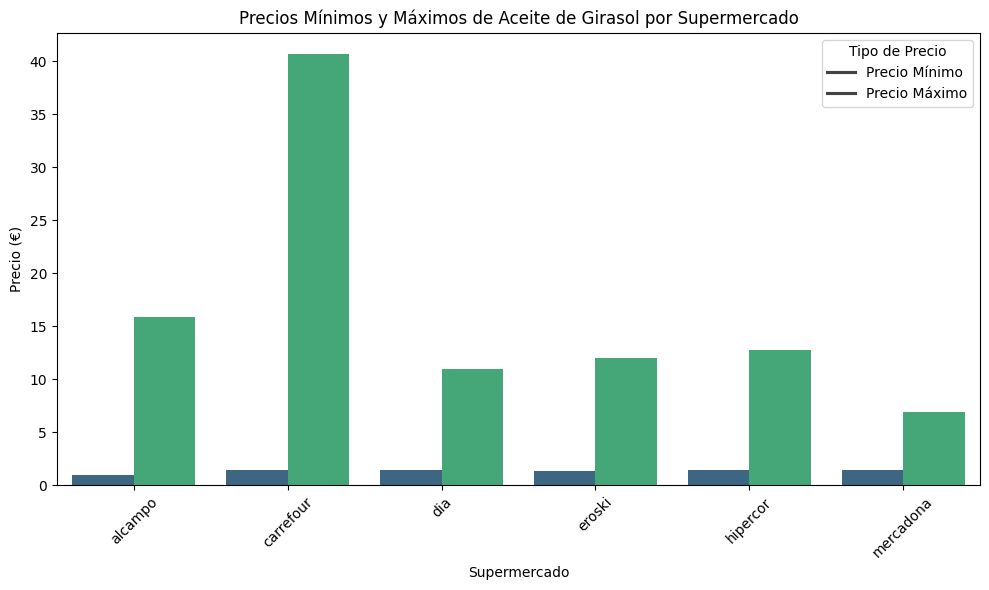

In [57]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# # Asegurarse de que las columnas tengan nombres adecuados
# df.columns = ['precio_minimo', 'precio_maximo', 'supermercado', 'categoria']

# Convertir el DataFrame a formato 'long'
df_long = pd.melt(df_min_max_leche, id_vars=['categoria', 'supermercado'], 
                  value_vars=['precio_minimo', 'precio_maximo'], 
                  var_name='tipo_precio', value_name='precio')

# Filtrar solo la categoría "aceite-de-girasol" si hay múltiples categorías en el DataFrame
df_aceite = df_long[df_long['categoria'] == 'aceite-de-girasol']

# Crear el gráfico de barras agrupado
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_aceite, 
    x='supermercado', 
    y='precio', 
    hue='tipo_precio', 
    palette="viridis"
)

# Personalizar etiquetas y título
plt.title("Precios Mínimos y Máximos de Aceite de Girasol por Supermercado")
plt.xlabel("Supermercado")
plt.ylabel("Precio (€)")
plt.legend(title="Tipo de Precio", labels=["Precio Mínimo", "Precio Máximo"])
plt.xticks(rotation=45)  # Asegura que los nombres de supermercados se vean claramente
plt.tight_layout()
plt.show()



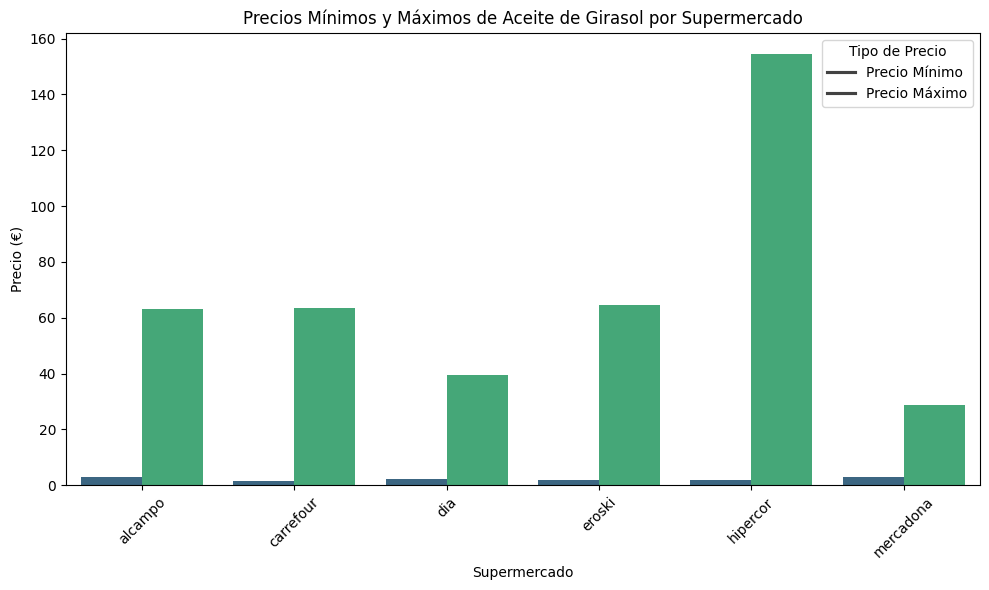

In [59]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# # Asegurarse de que las columnas tengan nombres adecuados
# df.columns = ['precio_minimo', 'precio_maximo', 'supermercado', 'categoria']

# Convertir el DataFrame a formato 'long'
df_long = pd.melt(df_min_max_leche, id_vars=['categoria', 'supermercado'], 
                  value_vars=['precio_minimo', 'precio_maximo'], 
                  var_name='tipo_precio', value_name='precio')

# Filtrar solo la categoría "aceite-de-girasol" si hay múltiples categorías en el DataFrame
df_aceite = df_long[df_long['categoria'] == 'aceite-de-oliva']

# Crear el gráfico de barras agrupado
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_aceite, 
    x='supermercado', 
    y='precio', 
    hue='tipo_precio', 
    palette="viridis"
)

# Personalizar etiquetas y título
plt.title("Precios Mínimos y Máximos de Aceite de Girasol por Supermercado")
plt.xlabel("Supermercado")
plt.ylabel("Precio (€)")
plt.legend(title="Tipo de Precio", labels=["Precio Mínimo", "Precio Máximo"])
plt.xticks(rotation=45)  # Asegura que los nombres de supermercados se vean claramente
plt.tight_layout()
plt.show()

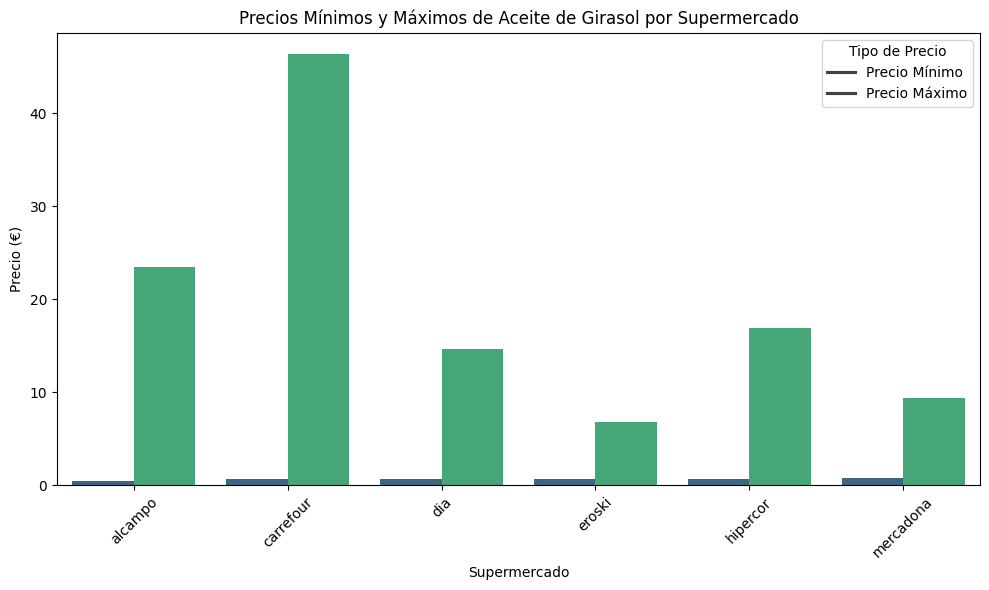

In [60]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# # Asegurarse de que las columnas tengan nombres adecuados
# df.columns = ['precio_minimo', 'precio_maximo', 'supermercado', 'categoria']

# Convertir el DataFrame a formato 'long'
df_long = pd.melt(df_min_max_leche, id_vars=['categoria', 'supermercado'], 
                  value_vars=['precio_minimo', 'precio_maximo'], 
                  var_name='tipo_precio', value_name='precio')

# Filtrar solo la categoría "aceite-de-girasol" si hay múltiples categorías en el DataFrame
df_aceite = df_long[df_long['categoria'] == 'leche']

# Crear el gráfico de barras agrupado
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_aceite, 
    x='supermercado', 
    y='precio', 
    hue='tipo_precio', 
    palette="viridis"
)

# Personalizar etiquetas y título
plt.title("Precios Mínimos y Máximos de Aceite de Girasol por Supermercado")
plt.xlabel("Supermercado")
plt.ylabel("Precio (€)")
plt.legend(title="Tipo de Precio", labels=["Precio Mínimo", "Precio Máximo"])
plt.xticks(rotation=45)  # Asegura que los nombres de supermercados se vean claramente
plt.tight_layout()
plt.show()

Evolucion de los precios a lo largo del tiempo (Aceite girasol)

In [9]:
# cursor=conexion.cursor()
# query_evolucion_precios="""
# SELECT dh.fecha, s.supermercado , c.categoria , sum(dh.variación) 
# OVER (PARTITION BY s.supermercado, c.categoria ORDER BY dh.fecha) AS Variacion_acumulada
# FROM datos_historicos dh 
# INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
# INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
# ORDER BY c.categoria, s.supermercado, dh.fecha;
# """
# cursor.execute(query_evolucion_precios)
# df_variacion_acumulada_precio = pd.DataFrame(cursor.fetchall())
# # cursor.close()
# # conexion.close()

In [29]:
# df_variacion_acumulada_precio[0] = pd.to_datetime(df_variacion_acumulada_precio[0])


In [4]:
cursor=conexion.cursor()
query_evolucion_precios_aceite_girasol="""
SELECT dh.fecha, s.supermercado , c.categoria , sum(dh.variación) 
OVER (PARTITION BY s.supermercado, c.categoria ORDER BY dh.fecha) AS Variacion_acumulada
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-girasol'
ORDER BY c.categoria, s.supermercado, dh.fecha;
"""
cursor.execute(query_evolucion_precios_aceite_girasol)
df_variacion_acumulada_precio_g = pd.DataFrame(cursor.fetchall())

In [5]:
df_variacion_acumulada_precio_g[0] = pd.to_datetime(df_variacion_acumulada_precio_g[0])

In [8]:
df_variacion_acumulada_precio_g.describe()

,0,3
count,6145,6145.000000
mean,2024-08-30 20:17:08.738811904,1.597850
min,2024-06-22 00:00:00,-3.720000
25%,2024-08-04 00:00:00,-0.680000
50%,2024-08-30 00:00:00,1.300000
75%,2024-09-26 00:00:00,3.980000
max,2024-10-26 00:00:00,8.060000
std,NaN,2.750483


<Axes: xlabel='0', ylabel='3'>

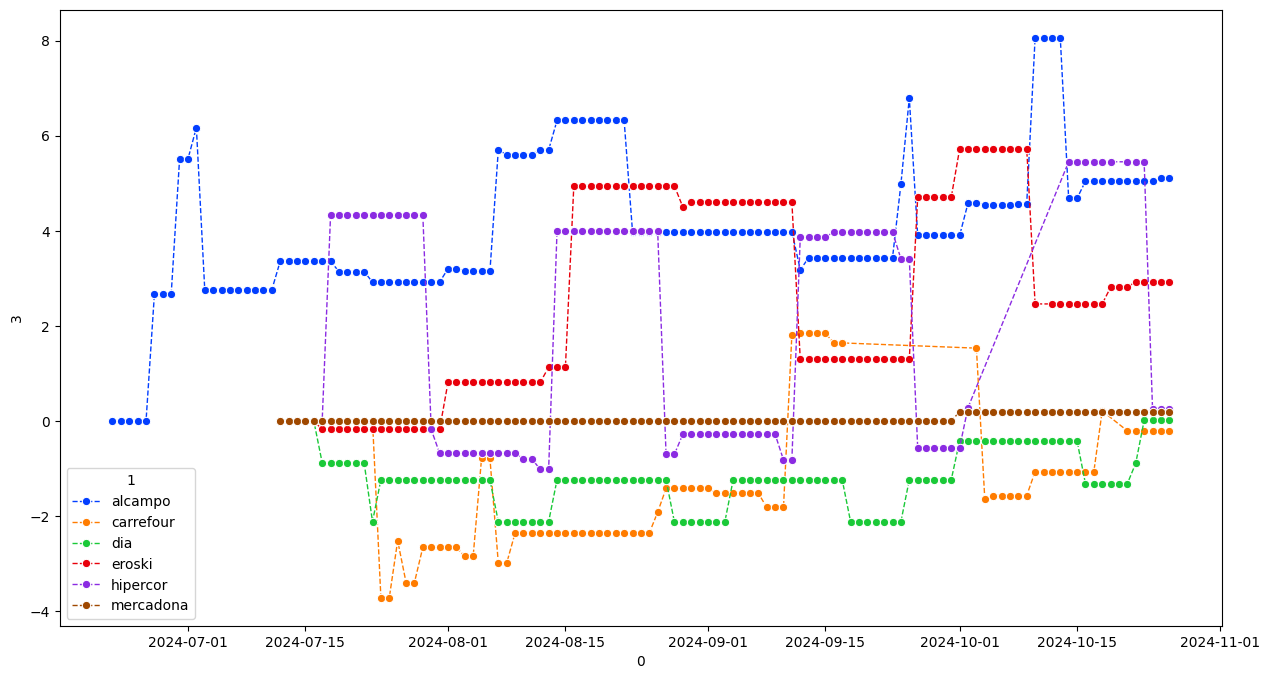

In [39]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_variacion_acumulada_precio_g[0],
              y = df_variacion_acumulada_precio_g[3], 
              hue = df_variacion_acumulada_precio_g[1], 
               marker = "o", 
                linewidth = 1, 
                palette="bright", 
                linestyle = "dashed", 
                errorbar = None)

Evolucion de los precios a lo largo del tiempo (Aceite de oliva)

In [9]:
cursor=conexion.cursor()
query_evolucion_precios_aceite_oliva="""
SELECT dh.fecha, s.supermercado , c.categoria , sum(dh.variación) 
OVER (PARTITION BY s.supermercado, c.categoria ORDER BY dh.fecha) AS Variacion_acumulada
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-oliva'
ORDER BY c.categoria, s.supermercado, dh.fecha;
"""
cursor.execute(query_evolucion_precios_aceite_oliva)
df_variacion_acumulada_precio_adeo = pd.DataFrame(cursor.fetchall())
# cursor.close()
# conexion.close()

In [10]:
df_variacion_acumulada_precio_adeo[0] = pd.to_datetime(df_variacion_acumulada_precio_adeo[0])


In [12]:
df_variacion_acumulada_precio_adeo.describe()

,0,3
count,58301,58301.000000
mean,2024-08-26 16:07:58.180477440,-78.226876
min,2024-06-22 00:00:00,-206.770000
25%,2024-07-30 00:00:00,-112.500000
50%,2024-08-25 00:00:00,-79.380000
75%,2024-09-22 00:00:00,-40.940000
max,2024-10-26 00:00:00,19.400000
std,NaN,44.339702


<Axes: xlabel='0', ylabel='3'>

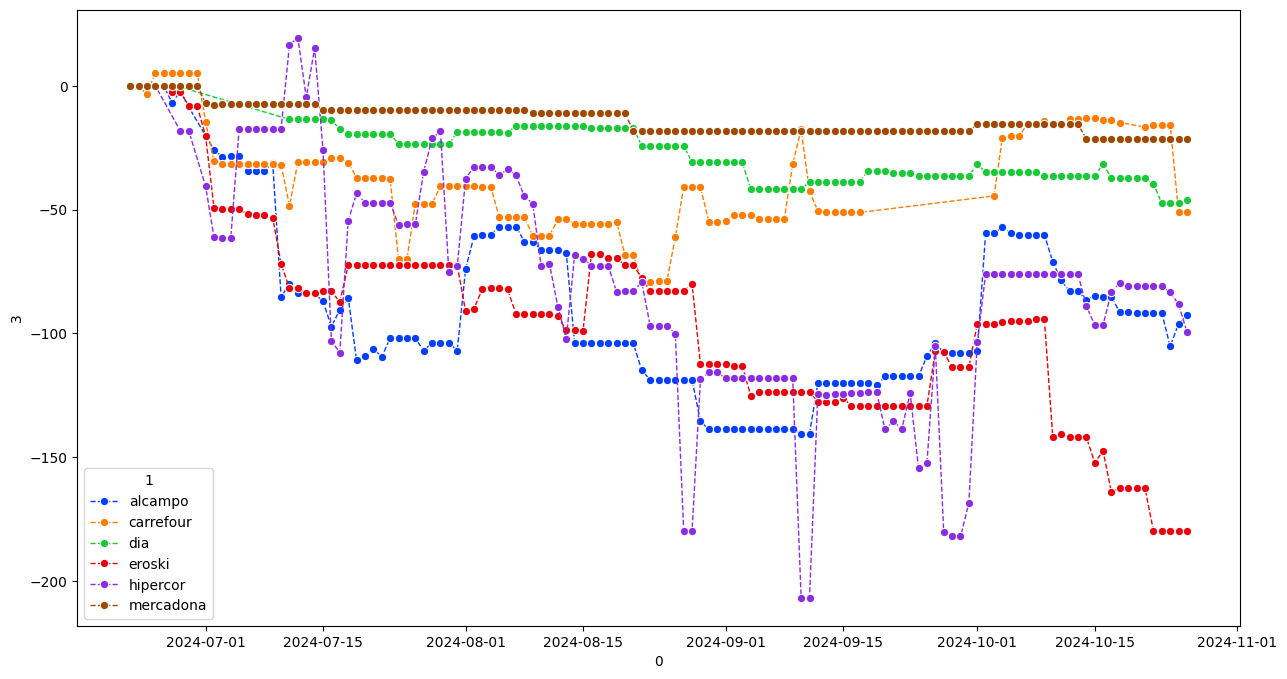

In [40]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_variacion_acumulada_precio_adeo[0],
              y = df_variacion_acumulada_precio_adeo[3], 
              hue = df_variacion_acumulada_precio_adeo[1], 
               marker = "o", 
                linewidth = 1, 
                palette="bright", 
                linestyle = "dashed", 
                errorbar = None)

In [13]:
cursor=conexion.cursor()
query_evolucion_precios_leche="""
SELECT dh.fecha, s.supermercado , c.categoria , sum(dh.variación) 
OVER (PARTITION BY s.supermercado, c.categoria ORDER BY dh.fecha) AS Variacion_acumulada
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'leche'
ORDER BY c.categoria, s.supermercado, dh.fecha;
"""
cursor.execute(query_evolucion_precios_leche)
df_variacion_acumulada_precio_leche = pd.DataFrame(cursor.fetchall())

In [14]:
df_variacion_acumulada_precio_leche[0] = pd.to_datetime(df_variacion_acumulada_precio_leche[0])

In [15]:
df_variacion_acumulada_precio_leche.head()

,0,1,2,3
0,2024-07-15,alcampo,leche,0.0
1,2024-07-15,alcampo,leche,0.0
2,2024-07-15,alcampo,leche,0.0
3,2024-07-15,alcampo,leche,0.0
4,2024-07-15,alcampo,leche,0.0


<Axes: xlabel='0', ylabel='3'>

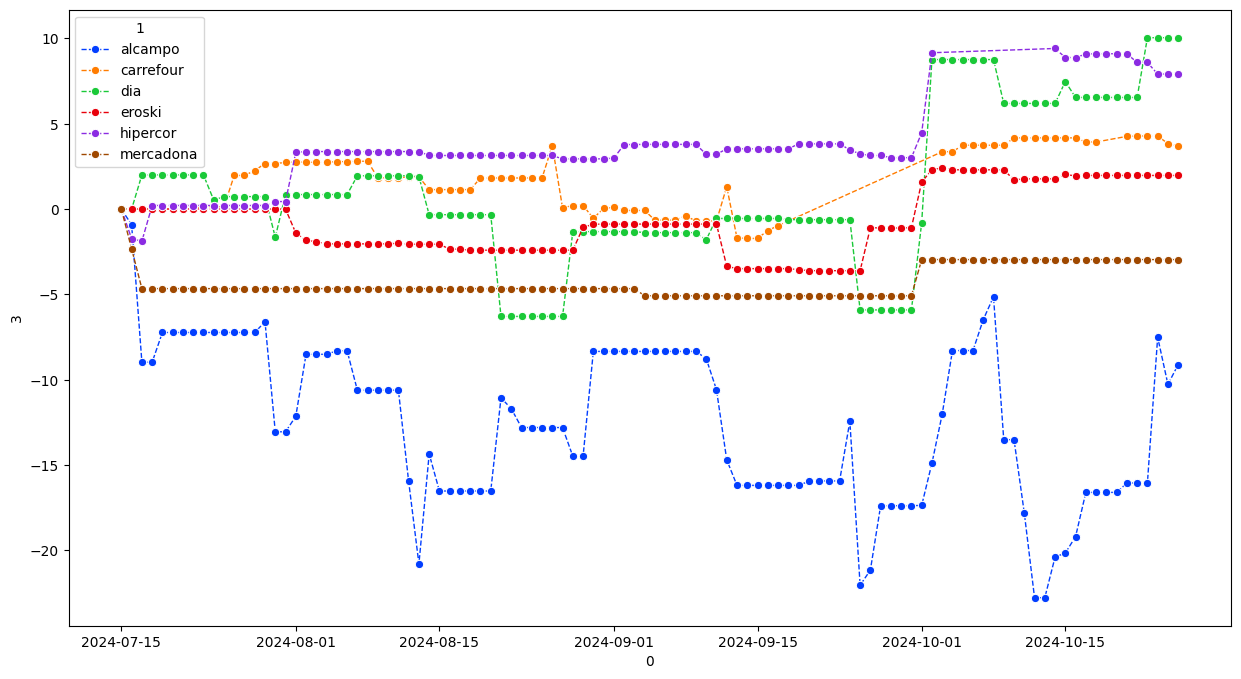

In [18]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_variacion_acumulada_precio_leche[0],
              y = df_variacion_acumulada_precio_leche[3], 
              hue = df_variacion_acumulada_precio_leche[1], 
               marker = "o", 
                linewidth = 1, 
                palette="bright", 
                linestyle = "dashed", 
                errorbar = None)

Anomalías de precios por tiempo (aceite de girasol)

In [19]:
#variacion buena por picadas

cursor=conexion.cursor()
query_anomalias_girasol="""
SELECT fecha, s.supermercado , c.categoria , sum(dh.variación) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-girasol'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_anomalias_girasol)
df_anomalias_girasol= pd.DataFrame(cursor.fetchall())

In [20]:
df_anomalias_girasol[0] = pd.to_datetime(df_anomalias_girasol[0])

In [21]:
df_anomalias_girasol.head()

,0,1,2,3
0,2024-09-07,mercadona,aceite-de-girasol,0.0
1,2024-07-19,dia,aceite-de-girasol,0.0
2,2024-07-30,alcampo,aceite-de-girasol,0.0
3,2024-07-13,eroski,aceite-de-girasol,0.0
4,2024-10-14,mercadona,aceite-de-girasol,0.0


In [22]:
df_anomalias_girasol.describe()

,0,3
count,631,631.000000
mean,2024-08-30 15:44:47.163233024,0.013106
min,2024-06-22 00:00:00,-5.200000
25%,2024-08-04 00:00:00,0.000000
50%,2024-08-30 00:00:00,0.000000
75%,2024-09-27 00:00:00,0.000000
max,2024-10-26 00:00:00,5.170000
std,NaN,0.767295


<Axes: xlabel='0', ylabel='3'>

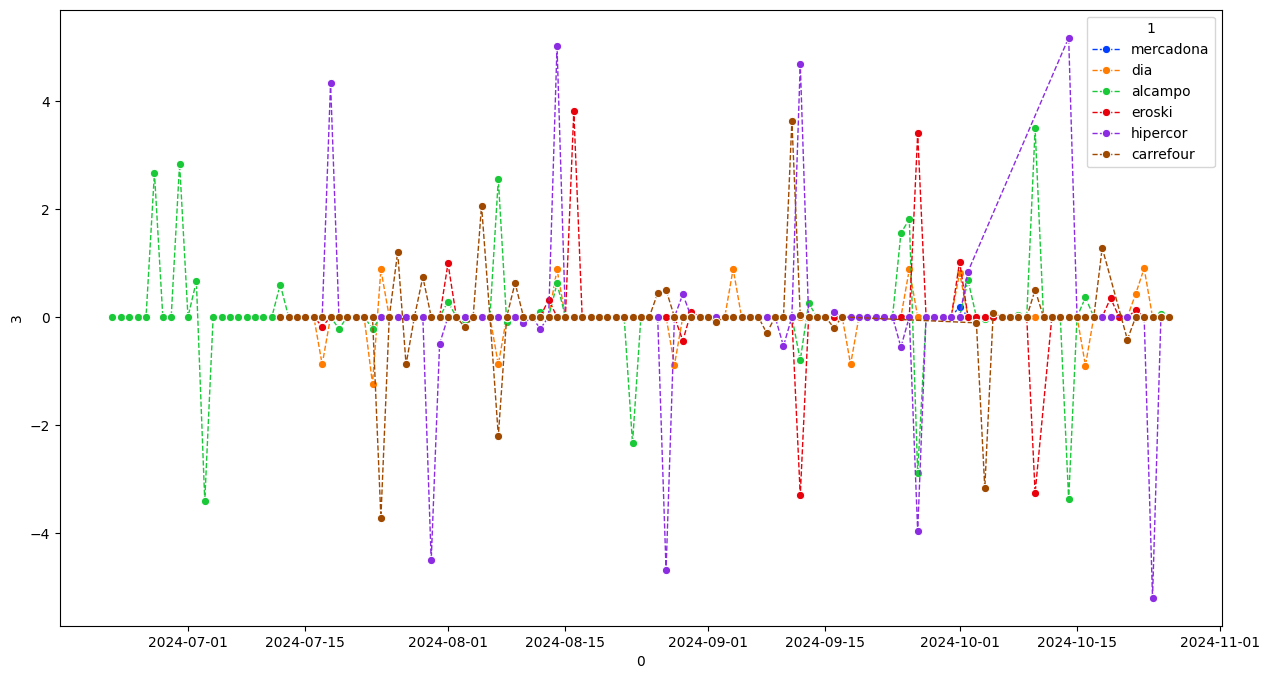

In [23]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_anomalias_girasol[0],
              y = df_anomalias_girasol[3], 
              hue = df_anomalias_girasol[1], 
               marker = "o", 
                linewidth = 1, 
                palette="bright", 
                linestyle = "dashed", 
                errorbar = None)

Anomalías por aceite de oliva

In [29]:
#variacion buena por picadas

cursor=conexion.cursor()
query_anomalias_aceiteoliva="""
SELECT fecha, s.supermercado , c.categoria , sum(dh.variación) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-oliva'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_anomalias_aceiteoliva)
df_anomalias_oliva= pd.DataFrame(cursor.fetchall())

In [30]:
df_anomalias_oliva[0] = pd.to_datetime(df_anomalias_oliva[0])

In [31]:
df_anomalias_oliva.head()

,0,1,2,3
0,2024-09-07,mercadona,aceite-de-oliva,0.00
1,2024-07-19,dia,aceite-de-oliva,0.00
2,2024-07-30,alcampo,aceite-de-oliva,-0.01
3,2024-07-13,eroski,aceite-de-oliva,-2.11
4,2024-10-14,mercadona,aceite-de-oliva,-5.88


In [32]:
df_anomalias_oliva.describe()

,0,3
count,720,720.000000
mean,2024-08-25 02:03:59.999999744,-0.680792
min,2024-06-22 00:00:00,-88.580000
25%,2024-07-26 00:00:00,0.000000
50%,2024-08-25 00:00:00,0.000000
75%,2024-09-25 00:00:00,0.000000
max,2024-10-26 00:00:00,82.350000
std,NaN,11.247102


<Axes: xlabel='0', ylabel='3'>

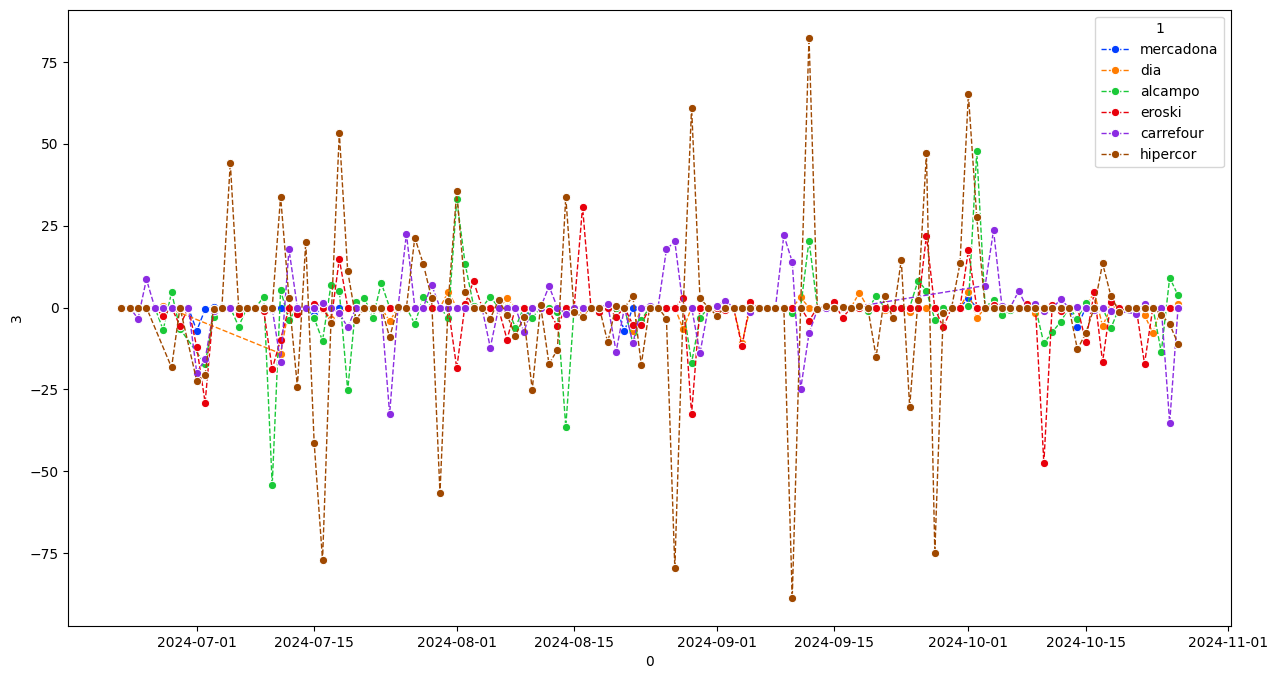

In [33]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_anomalias_oliva[0],
              y = df_anomalias_oliva[3], 
              hue = df_anomalias_oliva[1], 
               marker = "o", 
                linewidth = 1, 
                palette="bright", 
                linestyle = "dashed", 
                errorbar = None)

Anomalías por leche

In [34]:
#variacion buena por picadas

cursor=conexion.cursor()
query_anomalias_leche="""
SELECT fecha, s.supermercado , c.categoria , sum(dh.variación) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'leche'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_anomalias_leche)
df_anomalias_leche= pd.DataFrame(cursor.fetchall())

In [35]:
df_anomalias_leche[0] = pd.to_datetime(df_anomalias_leche[0])

In [36]:
df_anomalias_leche.head()

,0,1,2,3
0,2024-09-07,mercadona,leche,0.00
1,2024-07-19,dia,leche,0.00
2,2024-07-30,alcampo,leche,-6.45
3,2024-10-14,mercadona,leche,0.00
4,2024-08-31,eroski,leche,0.01


In [37]:
df_anomalias_leche.describe()

,0,3
count,596,596.000000
mean,2024-09-03 05:09:15.704698112,0.019362
min,2024-07-15 00:00:00,-9.610000
25%,2024-08-08 00:00:00,0.000000
50%,2024-09-02 00:00:00,0.000000
75%,2024-09-29 00:00:00,0.000000
max,2024-10-26 00:00:00,9.560000
std,NaN,1.345268


<Axes: xlabel='0', ylabel='3'>

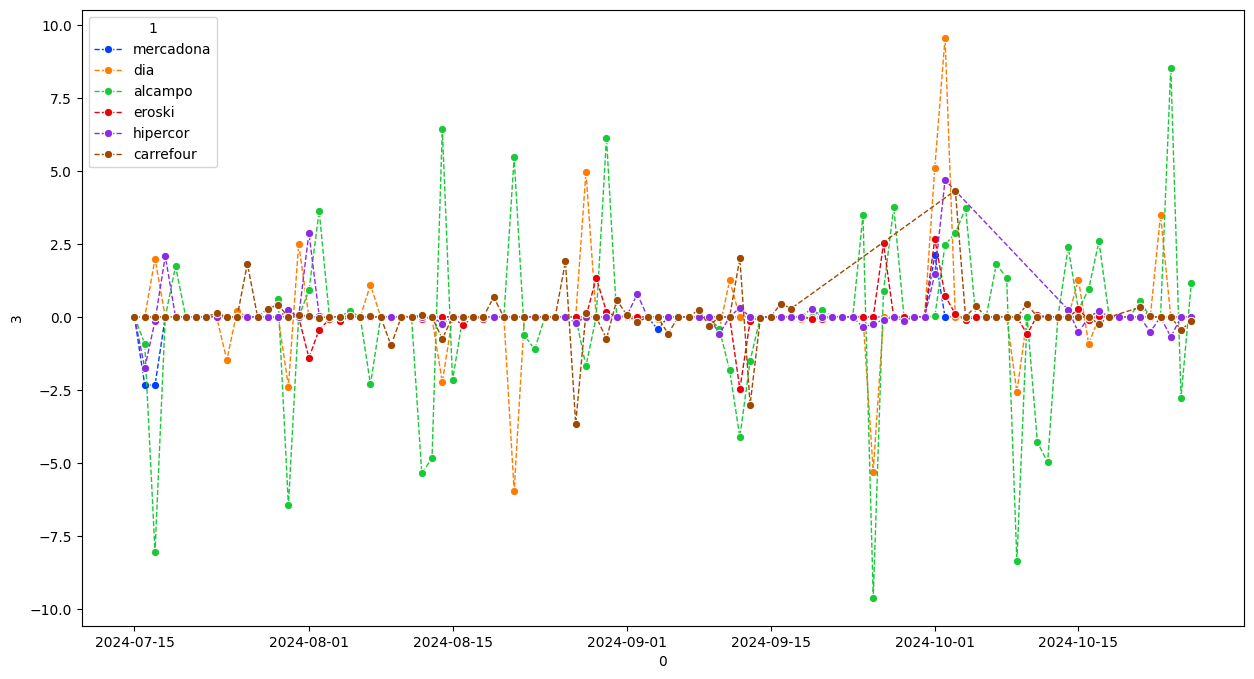

In [38]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_anomalias_leche[0],
              y = df_anomalias_leche[3], 
              hue = df_anomalias_leche[1], 
               marker = "o", 
                linewidth = 1, 
                palette="bright", 
                linestyle = "dashed", 
                errorbar = None)

Cambios de precio Aceite de girasol

In [68]:
#variacion buena por picadas

cursor=conexion.cursor()
query_cambios_precio_girasol="""
SELECT fecha, s.supermercado , c.categoria , avg(dh.precio) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'leche'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_cambios_precio_girasol)
df_cambios_girasol= pd.DataFrame(cursor.fetchall())

In [69]:
df_cambios_girasol[0] = pd.to_datetime(df_cambios_girasol[0])

In [70]:
df_cambios_girasol.describe()

,0,3
count,596,596.000000
mean,2024-09-03 05:09:15.704698112,2.821844
min,2024-07-15 00:00:00,1.434906
25%,2024-08-08 00:00:00,1.572158
50%,2024-09-02 00:00:00,3.621481
75%,2024-09-29 00:00:00,4.032564
max,2024-10-26 00:00:00,5.248553
std,NaN,1.191561


<Axes: xlabel='0', ylabel='3'>

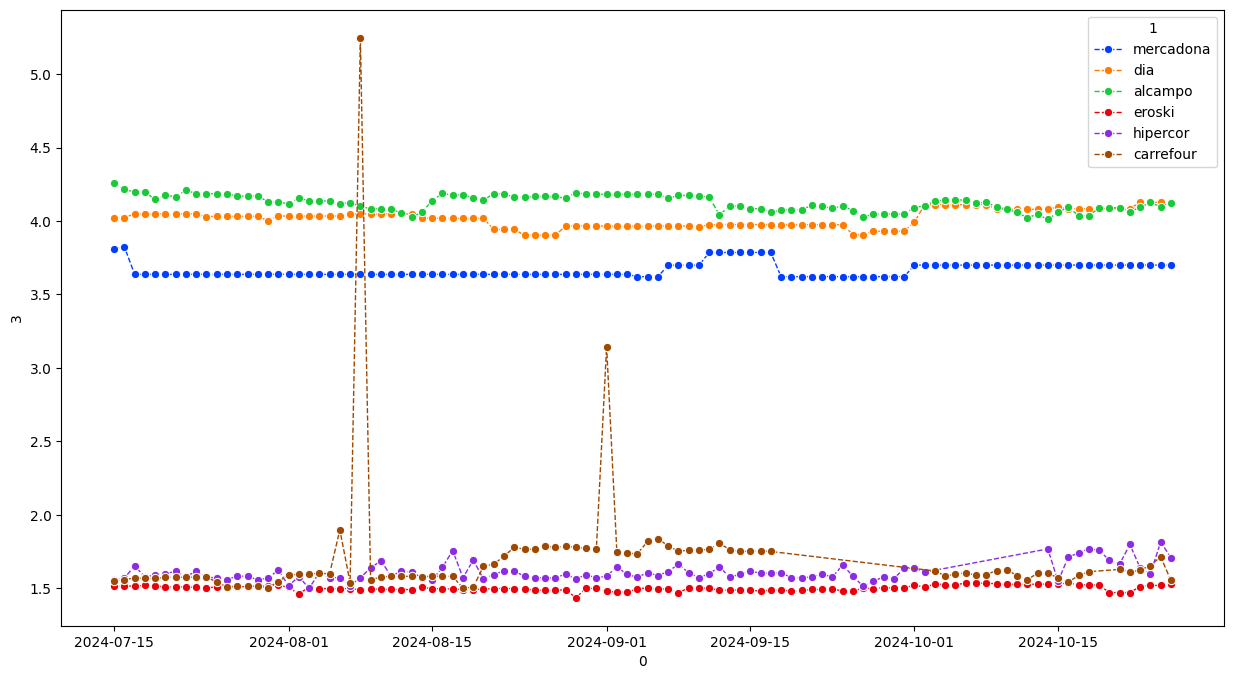

In [71]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_cambios_girasol[0],
              y = df_cambios_girasol[3], 
              hue = df_cambios_girasol[1], 
               marker = "o", 
                linewidth = 1, 
                palette="bright", 
                linestyle = "dashed", 
                errorbar = None)

In [64]:
#variacion buena por picadas

cursor=conexion.cursor()
query_cambios_precio_girasol="""
SELECT fecha, s.supermercado , c.categoria , sum(dh.precio) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'leche'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_cambios_precio_girasol)
df_cambios_girasol= pd.DataFrame(cursor.fetchall())

In [65]:
df_cambios_girasol[0] = pd.to_datetime(df_cambios_girasol[0])

In [66]:
df_cambios_girasol.describe()

,0,3
count,596,596.000000
mean,2024-09-03 05:09:15.704698112,304.865101
min,2024-07-15 00:00:00,94.650000
25%,2024-08-08 00:00:00,141.960000
50%,2024-09-02 00:00:00,272.780000
75%,2024-09-29 00:00:00,338.605000
max,2024-10-26 00:00:00,754.090000
std,NaN,207.597856


<Axes: xlabel='0', ylabel='3'>

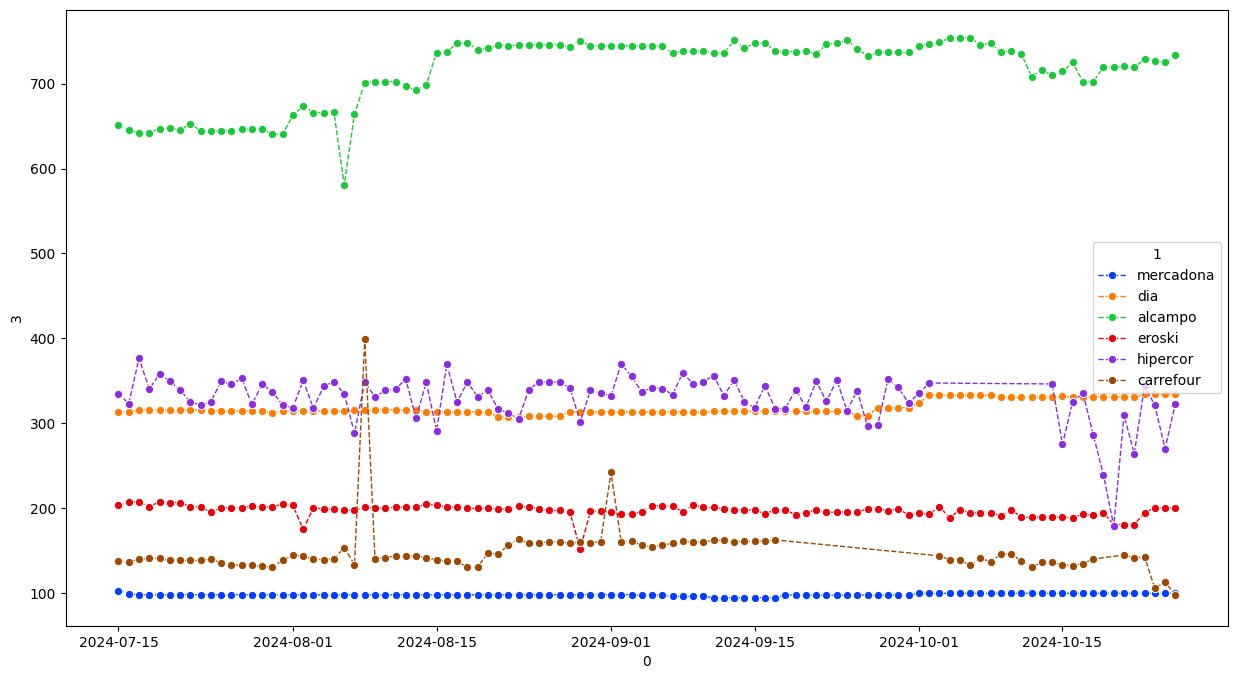

In [67]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_cambios_girasol[0],
              y = df_cambios_girasol[3], 
              hue = df_cambios_girasol[1], 
               marker = "o", 
                linewidth = 1, 
                palette="bright", 
                linestyle = "dashed", 
                errorbar = None)

Análisis de la Dispersión de Precios: Evaluar la variabilidad de los precios de un mismo producto en diferentes supermercados.

In [86]:
cursor=conexion.cursor()
query_dispersion_precios= """
SELECT c.categoria , s.supermercado, 
avg(dh.precio) AS precio_promedio,
min(dh.precio) AS precio_minimo,
max(dh.precio) AS precio_maximo
FROM datos_historicos dh 
inner JOIN supermercado s 
ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c 
ON dh.id_categoria = c.id_categoria 
GROUP BY c.categoria, s.supermercado 
ORDER BY c.categoria;
"""
cursor.execute(query_dispersion_precios)
df_dispersion_precios= pd.DataFrame(cursor.fetchall())

In [87]:
df_dispersion_precios.head()

,0,1,2,3,4
0,aceite-de-girasol,alcampo,4.131640,1.00,15.88
1,aceite-de-girasol,carrefour,8.183978,1.45,40.67
2,aceite-de-girasol,dia,5.100328,1.49,10.99
3,aceite-de-girasol,eroski,3.522112,1.39,11.99
4,aceite-de-girasol,hipercor,3.613664,1.40,12.79


Comparación de Precios Promedio: Calcular y comparar los precios promedio de cada producto en diferentes supermercados.

In [61]:
cursor=conexion.cursor()
query_comparar_precios = """
SELECT round(CAST (avg(precio) AS NUMERIC), 2) AS precio_pomedio, s.supermercado , c.categoria 
FROM datos_historicos dh 
inner JOIN supermercado s 
ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c 
ON dh.id_categoria = c.id_categoria 
GROUP BY s.supermercado , c.categoria 
ORDER BY c.categoria;
"""
cursor.execute(query_comparar_precios)
df_comparacion_precios = pd.DataFrame(cursor.fetchall())

In [62]:
df_comparacion_precios.head()

,0,1,2
0,4.13,alcampo,aceite-de-girasol
1,8.18,carrefour,aceite-de-girasol
2,5.10,dia,aceite-de-girasol
3,3.52,eroski,aceite-de-girasol
4,3.61,hipercor,aceite-de-girasol


Promedio

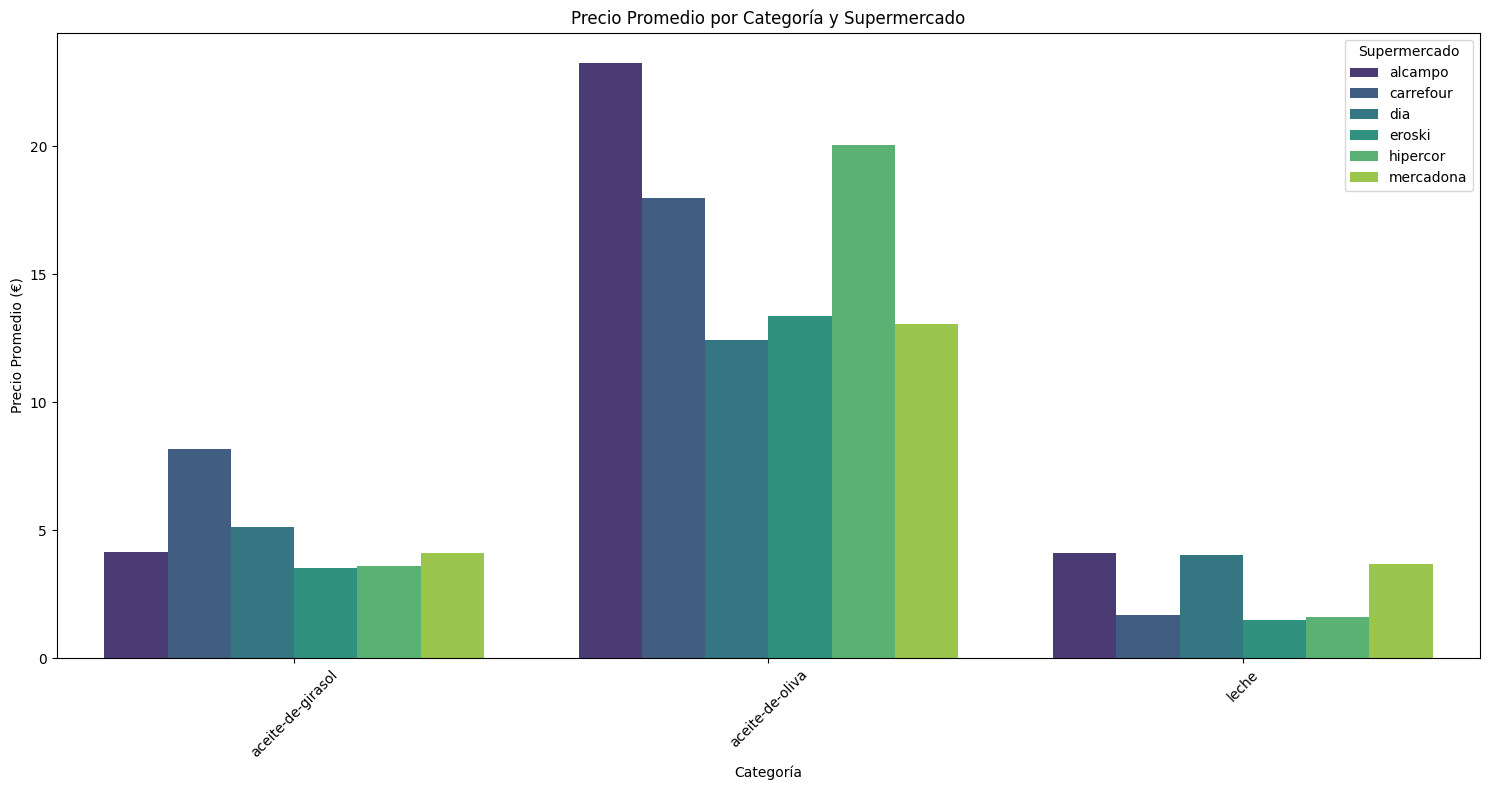

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes el DataFrame resultado de la consulta SQL con columnas:
# 'precio_promedio', 'supermercado', 'categoria'

plt.figure(figsize=(15, 8))
sns.barplot(
    data=df_comparacion_precios, 
    x=2, 
    y=0, 
    hue=1, 
    palette="viridis"
)

# Personalizar etiquetas y título
plt.title("Precio Promedio por Categoría y Supermercado")
plt.xlabel("Categoría")
plt.ylabel("Precio Promedio (€)")
plt.xticks(rotation=45)
plt.legend(title="Supermercado")
plt.tight_layout()
plt.show()
